# Assignment 4: Correlation Analysis and Bootstrapping

## Objective

The field of statistics is divided into two major parts: descriptive and inferential. In this assignment, we will cover two important topics in statistics: correlation analysis and bootstrapping, where the former belongs to the descriptive part and the latter belongs to the inferential part. After this assignment, you will be able to answer the following questions:

1. How to visualize the relationship between two variables?  
2. What is Pearson's correlation? How to compute it?
3. What is Spearman's rank correlation? How to compute it?
4. What's the difference between Pearson's correlation and Spearman's rank correlation? 
5. How to estimate a population parameter based on a sample?
6. How to use the bootstrap to quantify the uncertainty of an estimated value?

**Requirements:**
* Use [pandas](https://pandas.pydata.org/) to manipulate data.
* Use [matplotlib](https://matplotlib.org/) or [seaborn](https://seaborn.pydata.org) to make plots.
* Please pay attention to visualization principles. 


The data can be downloaded from [A4-data.zip](A4-data.zip).


## Part 1. Correlation Analysis

As a data scientist, you often face this kind of question: "Are A and B correlated?" For example, 

* Do Canadian Currency and Oil Price move together?
* Do Vancouver Housing Price and US Stock Market have any correlation?
* Are GPA and Gender independent? 

To answer these questions, you need to conduct a correlation analysis. 

Imagine you are a data scientist working at a real-estate company. You download a property_tax_report from this [webpage](https://data.vancouver.ca/datacatalogue/propertyTax.htm). The dataset contains information on properties from BC Assessment (BCA) and City sources in 2019.  You can find the schema information of the dataset from this [webpage](http://data.vancouver.ca/datacatalogue/propertyTaxAttributes.htm). 

You may think that for a newly built house, it tends to have a higher price than the ones built decades ago. In this assignment, your first job is to figure out whether YEAR_BUILT and HOUSE_PRICE are correlated. 

We first load the data as a DataFrame. 

In [1]:
import pandas as pd

df = pd.read_csv("property_tax_report_2019.csv")


df['HOUSE_PRICE'] = df.apply(lambda x: (x['CURRENT_LAND_VALUE'] \
                                        +x['CURRENT_IMPROVEMENT_VALUE'])/1000000.0, axis = 1)

### Task A. Visualizations

Since the housing price varies a lot by locations, we will only consider the houses whose postcode starts with 'V6A'. Furthermore, we remove the houses that were built before 1900.

<img src='img/v6a.png' width='500' />

In the following, please make two subplots in one row. For the left subplot, it is a scatter plot with X = `YEAR_BUILT` and Y = `HOUSE_PRICE`; for the right subplot, it is a hexbin plot (gridsize = 20) with X = `YEAR_BUILT` and Y = `HOUSE_PRICE`.

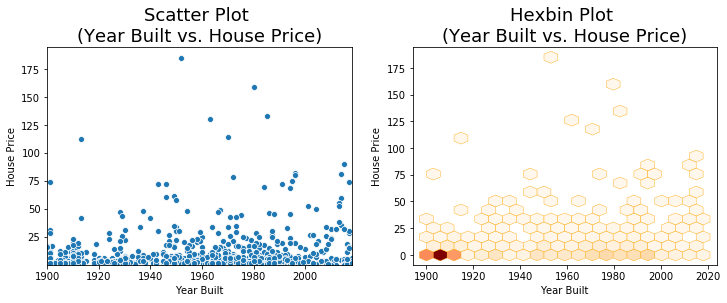

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt 


# filter data to only years greater than equal to 1900 and postal code starting with V6A
df_filtered = df.loc[  (df['YEAR_BUILT'] >= 1900) \
                     & (df['PROPERTY_POSTAL_CODE'].str.startswith('V6A')) \
                     & (df['LEGAL_TYPE'] == 'LAND')]

# get min and max house price to set ylim
min_house_price = df_filtered['HOUSE_PRICE'].min()
max_house_price = df_filtered['HOUSE_PRICE'].max()

# get min and max year to set xlim
min_year_built = df_filtered['YEAR_BUILT'].min()
max_year_built = df_filtered['YEAR_BUILT'].max()

# set figure size
plt.figure(figsize=(12,4))


# draw scatter plot
plt.subplot(1,2,1)
plot1 = sns.scatterplot(x='YEAR_BUILT', y='HOUSE_PRICE', data=df_filtered)
plot1.set(xlim=(min_year_built, max_year_built), ylim=(min_house_price, max_house_price * 1.05))
plot1.set(xlabel='Year Built', ylabel='House Price')
plot1.set_title(label='Scatter Plot \n(Year Built vs. House Price)', fontsize='18')


# draw hexbin plot
plt.subplot(1,2,2)
plot2 = plt.hexbin(x='YEAR_BUILT', y='HOUSE_PRICE', data=df_filtered, \
                   gridsize=20, mincnt=1, linewidths=0.4, cmap='OrRd', color='Orange')
plt.xlabel('Year Built')
plt.ylabel('House Price')
plt.title('Hexbin Plot \n(Year Built vs. House Price)', fontsize='18');

Please write down the **two** most interesting findings that you draw from the plot.

**Findings**
1. <font color='red'>Generally, house prices built in different years tend to be less than 35M Dollars in this area of the city. Specifically, years from 1900 to 1918 has the most number of houses built with price less that 5M Dollars.</font>
2. <font color='red'>As we move forward from year 1920 toward 2020, we can see that there are more houses built having higher prices.</font>

The above plots provide a general impression of the relationship between variables. There are some other visualizations that can provide more insights. One option is to bin one variable and plot percentiles of the other. 


In the following, please make three subplots in a row, where each subplot is a scatter plot with X = YEAR_BUILT and Y = HOUSE_PRICE. 
* The first subplot shows how the 25th percentile of `HOUSE_PRICE` changes over years (X = `YEAR_BUILT`, Y = `25TH_HOUSE_PRICE`); 
* The second subplot shows how the 50th percentile of `HOUSE_PRICE` changes over years (X = `YEAR_BUILT`, Y = `50TH_HOUSE_PRICE`); 
* The third subplot shows how the 75th percentile of `HOUSE_PRICE` changes over years (X = `YEAR_BUILT`, Y = `75TH_HOUSE_PRICE`);  


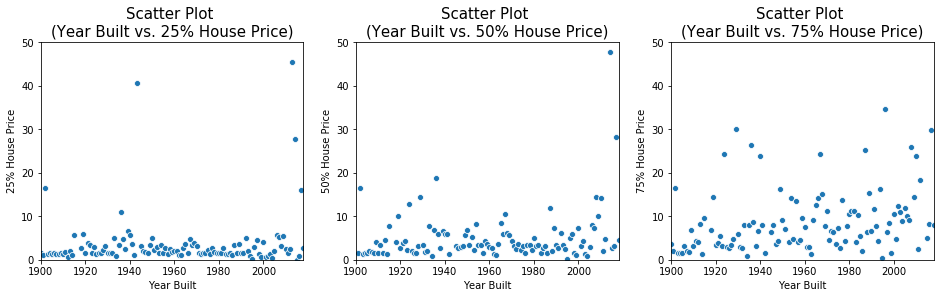

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt 

def draw_plot(df_input, x_axis, y_axis, x_title, y_title, plot_index):
    # set plot place
    plt.subplot(1,3,plot_index)


    # draw plot
    ax = sns.scatterplot(x=x_axis, y=y_axis, data=df_input)
    ax.set(xlim=(min_year_built, max_year_built), ylim=(0,50))
    ax.set(xlabel=x_title, ylabel=y_title)
    ax.set_title('Scatter Plot \n(Year Built vs. ' + y_title + ')', fontsize=15)


# build matrix grouped by year and hold 25, 50, 75% as columns
def build_matrix(df_input):
    df_group = df_filtered[['YEAR_BUILT', 'HOUSE_PRICE']].groupby('YEAR_BUILT').describe()
    df_quantile = df_group['HOUSE_PRICE'][['25%', '50%', '75%']].reset_index()
    df_cor = df_quantile.rename(columns={'25%': '25TH_HOUSE_PRICE', '50%': '50TH_HOUSE_PRICE', '75%': '75TH_HOUSE_PRICE'})
    
    return df_cor


# get cor matrix
dfcor = build_matrix(df_filtered)

# draw plots
plt.figure(figsize=(16,4))
draw_plot(dfcor, 'YEAR_BUILT', '25TH_HOUSE_PRICE', 'Year Built', '25% House Price', 1)
draw_plot(dfcor, 'YEAR_BUILT', '50TH_HOUSE_PRICE', 'Year Built', '50% House Price', 2)
draw_plot(dfcor, 'YEAR_BUILT', '75TH_HOUSE_PRICE', 'Year Built', '75% House Price', 3)

Please write down the **two** most interesting findings that you draw from the plot.

**Findings**
1. <font color='red'>25% of house price values in most of the years from 1900 to 2020 generally lies between 0 and 10M Dollars.</font>
2. <font color='red'>Based on 75% of house price values, we can see that house prices have experienced more visible increase as we move from 1900 to 2020.</font>

### Task B. Correlation Coefficient

A correlation coefficient is a numerical measure of some type of correlation, meaning a statistical relationship between a pair of variables. 

In the following, please implement `calc_pearson()` and `calc_spearman()`, respectively. Note that you are *NOT* allowed to use [corr](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.corr.html) from Pandas or [pearsonr](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html#scipy.stats.pearsonr)/[spearmanr](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html#scipy.stats.spearmanr) from scipy.stats to do this task. In other words, you need to implement the actual algorithms for pearson and spearman.

In [11]:
import math 
import numpy as np

def preprocess_df(df, x, y):
    # copy dataframe to a new dataframe
    df_local = df.copy()

    # create a new column named new_x using x column
    df_local['new_x'] = df_local[x]

    # create a new column named new_y using y column
    df_local['new_y'] = df_local[y]

    # drop rows in which new_x , new_y na values are na
    df_valid = df_local[['new_x','new_y']].dropna()
    
    # return valid dataframe
    return df_valid
    
def calc_pearson(df, x, y):
    # pre process data frame (remove na, apply naming conventions, etc.)
    df_valid = preprocess_df(df, x, y)
    
    # calculate mean of each column
    mean_x = df_valid['new_x'].sum() / df_valid['new_x'].count()
    mean_y = df_valid['new_y'].sum() / df_valid['new_y'].count()
    
    # calculate x deviation in each row
    df_valid['xdev'] = df_valid['new_x'] - mean_x
    
    # calculate y deviation in each row
    df_valid['ydev'] = df_valid['new_y'] - mean_y
    
    # calculate cross product of x,y deviation in each row
    df_valid['xy_cp'] = df_valid['xdev'] * df_valid['ydev']
    
    # calculate x deviation to the power of 2 in each row
    df_valid['xdev_p2'] = df_valid['xdev'] * df_valid['xdev']
    
    # calculate y deviation to the power of 2
    df_valid['ydev_p2'] = df_valid['ydev'] * df_valid['ydev']
    
    # calculate sum of cross products of x,y deviation
    top = df_valid['xy_cp'].sum()
    
    # calculate sum of x deviation to the power of 2
    sum_xdev_p2 = df_valid['xdev_p2'].sum()
    
    # calculate sum of y deviation to the power of 2
    sum_ydev_p2 = df_valid['ydev_p2'].sum()
    
    # calculate square root of sum of x,y deviations to the power of 2
    bottom = math.sqrt(sum_xdev_p2) * math.sqrt(sum_ydev_p2)
    
    # return result
    return top / bottom
    

def calc_spearman(df, x, y):
    df_valid = preprocess_df(df, x, y)

    df_valid['rx'] = df_valid['new_x'].rank(ascending=False, method='average')
    df_valid['ry'] = df_valid['new_y'].rank(ascending=False, method='average')
    
    return calc_pearson(df_valid, 'rx', 'ry')


pearson = calc_pearson(df_filtered, 'HOUSE_PRICE', 'YEAR_BUILT')
spearman = calc_spearman(df_filtered, 'HOUSE_PRICE', 'YEAR_BUILT')


print("\n")
print("Pearson correlation: %2.6f" % (pearson))
print("Spearman correlation: %2.6f" % (spearman))
print("\n")



Pearson correlation: 0.208189
Spearman correlation: 0.219521




Then, you can use these two functions to compute the Pearson's correlation as well as Spearman's rank correlation for three pairs of variables: <`25TH_HOUSE_PRICE`, `YEAR_BUILT`>, <`50TH_HOUSE_PRICE`, `YEAR_BUILT`>, and <`75TH_HOUSE_PRICE`, `YEAR_BUILT`>. 

In [12]:
print(dfcor.head(10))
print()

for TH in ["25TH", "50TH", "75TH"]:
    print(TH+"_HOUSE_PRICE\t pearson=%f\t spearman=%f"  \
          %(calc_pearson(dfcor, "YEAR_BUILT", TH+"_HOUSE_PRICE"), \
            calc_spearman(dfcor, "YEAR_BUILT", TH+"_HOUSE_PRICE")))

   YEAR_BUILT  25TH_HOUSE_PRICE  50TH_HOUSE_PRICE  75TH_HOUSE_PRICE
0      1900.0          1.550200           1.62600            3.5750
1      1901.0          1.189925           1.50700            2.0005
2      1902.0         16.614000          16.61400           16.6140
3      1903.0          1.246150           1.42620            1.5063
4      1904.0          1.454500           1.57920            1.6143
5      1905.0          1.378200           1.49100            1.6730
6      1906.0          1.452350           2.01700            3.1472
7      1907.0          1.448550           1.71800            2.0550
8      1908.0          1.321000           1.47480            1.6970
9      1909.0          1.500225           4.04085            6.8510

25TH_HOUSE_PRICE	 pearson=0.112608	 spearman=0.033614
50TH_HOUSE_PRICE	 pearson=0.185711	 spearman=0.186584
75TH_HOUSE_PRICE	 pearson=0.225439	 spearman=0.389536


<img src="img/correlation-result.png" align="left" width="600" height="600">

Please write down the **two** most interesting findings that you draw from the result.

**Findings**
1. <font color='red'>Year built has the least correlation with 25% of house prices and the prices are completely independant of year built.</font>
2. <font color='red'>Correlation values (pearson, spearman) shows that year built has somehow a relation with house prices. spearman correlation score of 0.389536 shows that as years pass, the house prices also increase, but the increase amount is not consistent and linear.</font>

## Part 2. Bootstrapping

In reality, it is more often than not that you can only collect a sample of the data. Whenever you derive a conclusion from a sample (e.g., Vancouver's housing price has increased by 10% since last year), you should ALWAYS ask yourself: **"CAN I TRUST IT?"**. In other words, you want to know that if the same analysis was conducted on the full data, would the same conclusion be derived? In Part 2, you will learn how to use bootstrapping to answer this question. 

In [13]:
df_sample = pd.read_csv("property_tax_report_2019_sample.csv")

df_sample['CURRENT_PRICE'] = df_sample.apply(lambda x: x['CURRENT_LAND_VALUE'] \
                                             +x['CURRENT_IMPROVEMENT_VALUE'], axis = 1)

df_sample['PREVIOUS_PRICE'] = df_sample.apply(lambda x: x['PREVIOUS_LAND_VALUE'] \
                                              +x['PREVIOUS_IMPROVEMENT_VALUE'], axis = 1)

df_sample = df_sample[df_sample['LEGAL_TYPE'] == 'STRATA']

### Task 1. Analysis Result Without Bootstrapping

Please compute the median of PREVIOUS_PRICE and CURRENT_PRICE, respectively, and compare them in a bar chart.

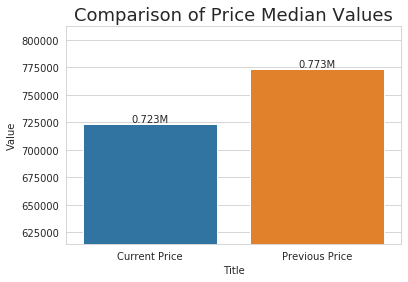

In [14]:
# --- Write your code below ---
import seaborn as sns
import matplotlib.pyplot as plt 


# get median of current and previous price
curr_price = df_sample['CURRENT_PRICE'].median()
prev_price = df_sample['PREVIOUS_PRICE'].median()


# create an array from both values
arr_curr_price=['Current Price', curr_price]
arr_prev_price=['Previous Price', prev_price]


# change arrays to pandas dataframe
df_result = pd.DataFrame(data=[arr_curr_price, arr_prev_price], columns=['Title', 'Value'])


# plot bar chart
sns.set_style('whitegrid')
ax = sns.barplot(x = 'Title', y = 'Value', data=df_result)
ax.set(ylim=(min(curr_price, prev_price) * 0.85, max(curr_price, prev_price) * 1.05))
ax.set_title('Comparison of Price Median Values', fontsize=18);


# show each bar value on top of the bars
for index, row in df_result.iterrows():
    ax.text(index, row[1], \
            str.format("%2.3fM" % (row[1] / 1000000)), \
            horizontalAlignment='center', \
            verticalAlignment='bottom')

### Task 2. Analysis Result With Bootstrapping

From the above chart, we find that the median of PREVIOUS_PRICE is about 0.77 M, and the median of CURRENT_PRICE is about 0.72 M. Since the numbers were obtained from the sample, **"CAN WE TRUST THESE NUMBERS?"**

In the following, please implement the bootstrap by yourself, and compute a 95%-confidence interval for each number. [This document](./MIT18_05S14_Reading24.pdf) gives a good tutorial about the bootstrap. You can find the description of the algorithm in Section 7.

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np

# get two columns required to work on
df_cprice = df_sample['CURRENT_PRICE'].dropna()
df_pprice = df_sample['PREVIOUS_PRICE'].dropna()

# get median of current and previous price
cprice_med = np.median(df_cprice)
pprice_med = np.median(df_pprice)
print("Current price median: %2.2f \nPrevious price median: %2.2f" % (cprice_med, pprice_med))
print("")

# lists too hold price *medians
arr_cprice_diff = []
arr_pprice_diff = []

# iterate 1000 times
for i in range(1000):
    # sample data from current,previous price dataframe
    df_resample_cprice = np.random.choice(df_cprice, size=len(df_cprice), replace=True)
    df_resample_pprice = np.random.choice(df_pprice, size=len(df_pprice), replace=True)
    
    # find *median of sampled current,previous price
    cprice_star_med = np.median(df_resample_cprice)
    pprice_star_med = np.median(df_resample_pprice)
    
    # append difference of current,previous *medians and current,previous median to their specific arrays
    arr_cprice_diff.append(cprice_star_med - cprice_med)
    arr_pprice_diff.append(pprice_star_med - pprice_med)
    
# sort both arrays
arr_cprice_diff.sort()
arr_pprice_diff.sort()

# define percentage for confidence
start_element = 0.025
end_element = 0.975

# get current price *medians start and end index
start_cprice_index = int(start_element * len(arr_cprice_diff))
end_cprice_index = int(end_element * len(arr_cprice_diff))

# get previous price *medians start and end index
start_pprice_index = int(start_element * len(arr_pprice_diff))
end_pprice_index = int(end_element * len(arr_pprice_diff))

# get elements from array based on indexes
cprice_start = arr_cprice_diff[start_cprice_index]
cprice_end = arr_cprice_diff[end_cprice_index]

# print 25, 975 items of current price *median
print("25th element of current price: %2.2f \n975th element of current price: %2.2f" % (cprice_start, cprice_end))
print()

# get elements from array based on indexes
pprice_start = arr_pprice_diff[start_pprice_index]
pprice_end = arr_pprice_diff[end_pprice_index]

# print 25, 975 items of previous price *median
print("25th element of previous price: %2.2f \n975th element of previous price: %2.2f" % (pprice_start, pprice_end))
print()

# calculate current price confident period
cprice_conf_start = cprice_med - cprice_end
cprice_conf_end = cprice_med - cprice_start
print("current price 95%%-confidence interval: [%2.2f,%2.2f]" % (cprice_conf_start,cprice_conf_end))

# calculate previous price confident period
pprice_conf_start = pprice_med - pprice_end
pprice_conf_end = pprice_med - pprice_start
print("previous price 95%%-confidence interval: [%2.2f,%2.2f]" % (pprice_conf_start,pprice_conf_end))

Current price median: 723000.00 
Previous price median: 773500.00

25th element of current price: -27000.00 
975th element of current price: 32000.00

25th element of previous price: -36500.00 
975th element of previous price: 36000.00

current price 95%-confidence interval: [691000.00,750000.00]
previous price 95%-confidence interval: [737500.00,810000.00]


## Submission

Complete the code in this notebook, and submit it to the CourSys activity Assignment 4.